<a href="https://colab.research.google.com/github/pds2122/capstone-project-kabobe/blob/main/models/model_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ndjson --quiet

In [ ]:
import ndjson
import requests
import pandas as pd
import gzip
from pathlib import Path
from google.colab import drive
import numpy as np
import gc
from collections import Counter
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Load train & test data

In [ ]:
# test dataset
drive.mount('/gdrive')
data_path = Path('/gdrive/MyDrive/industry_data_processed/data/final/')
file_name = 'df_test_de_sentiment.ndjson'

with open(data_path/file_name, "rt", encoding='UTF-8') as file:
    data = ndjson.load(file)
    
df_test = pd.DataFrame(data)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#train dataset
drive.mount('/gdrive')
data_path = Path('/gdrive/MyDrive/industry_data_processed/data/final/')
file_name = 'df_train_de_sentiment.ndjson'
with open(data_path/file_name, "rt", encoding='UTF-8') as file: # if gz, use >> with gzip.open()
    data = []
    data = [ndjson.loads(line) for line in file]

# get nested list, create flat-list, to fet data in DataFrame
flat_list = [item for sublist in data for item in sublist]
df_train = pd.DataFrame(flat_list)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#Tf–idf term weighting & logistic regression

Complementary infos: https://github.com/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/tfidf_scikit-learn.ipynb

In the process we explored out several combinations and options. All using the German filtered data.

* Input data: Single column and mutliple columns
* Training and Test data: Using
  * (1) Train dataset and performing a train-test-split
  * (2) Train and test data pre-splitted from SnapADDY
* Over- and undersampling

In the following the final logistic regression can be found. In the sections below the combinations are saved for completeness.

**Alternative: Single column on pre-splitted datasets**

In [ ]:
vectorizer = TfidfVectorizer(max_features=400000)

# integrate class_weight = 'balanced' for weighting underrepresented classes more
#n_jobs = 4 - TerminatedWorkerError with upsampled train - then set to n_jobs = 1
logit = LogisticRegression(C=40.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=4, random_state=15, solver='newton-cg')

# old parameters (before hypertuning)
#(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4, class_weight = 'balanced') 



In [ ]:
# get data in shape
train_X = df_train['concatenated'] 
train_y = df_train['industry_label']

test_X = df_test['concatenated'] 
test_y = df_test['industry_label']

In [ ]:
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)
train_y = train_y.tolist()
test_y = test_y.tolist()

train_X.shape, test_X.shape

((16809, 400000), (8396, 400000))

Fit model: Using column concatenated (contains all page content + additional Features from html)

In [ ]:
# when exchanging train_X, train_y make sure to execute over/undersampling first
# X_resampled_up, y_resampled_up ; train_X, train_y ; X_resampled_both, y_resampled_both; X_resampled_under, y_resampled_under

logit.fit(train_X, train_y) 

LogisticRegression(C=40.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=4, random_state=15, solver='newton-cg')

In [ ]:
gc.collect()

188

### Hyperparameter tuning

In [ ]:
# use shorter dataset for quicker processing
train_half = df_train.sample(frac=0.3).copy()
test_half = df_test.sample(frac=0.1).copy()

train_y = train_half['industry_label'].copy().values.reshape(-1, 1)
test_y = test_half['industry_label'].copy().values.reshape(-1, 1)

train_X = vectorizer.fit_transform(train_half['concatenated'] )
test_X = vectorizer.transform(test_half['concatenated'] )

train_y.tolist()
test_y.tolist()

train_X.shape, train_y.shape

((5043, 246382), (5043, 1))

In [ ]:
# set range of possible parameters of the logistic regression
params = {'C':[4e1,5e1,6e1],
          'class_weight':['balanced'],
          'random_state':[10,15,20,25],
          'solver':['newton-cg', 'sag', 'saga', 'lbfgs'],
          'multi_class':['multinomial'],
          'penalty':['l2','None']
          }

In [ ]:
random_search = RandomizedSearchCV(logit, param_distributions=params, n_iter=5, scoring='roc_auc', cv=5, verbose=3)

In [ ]:
# use for pipeline
#pipeline_RC = Pipeline(steps=[('t', column_trans), ('m',random_search)])
#pipeline_RC.fit(train_X, train_y.ravel())

In [ ]:
random_search.fit(train_X, train_y.ravel())

In [ ]:
# best parameters from search
random_search.best_params_

{'C': 40.0,
 'class_weight': 'balanced',
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'random_state': 15,
 'solver': 'newton-cg'}

In [ ]:
# best overall set up -> use this
random_search.best_estimator_

LogisticRegression(C=40.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=4, random_state=15, solver='newton-cg')

### Metrics & scores

Report

In [ ]:
score = logit.score(test_X, test_y)
print(score)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# https://scikit-learn.org/stable/modules/model_evaluation.html
predicted = logit.predict(test_X)
logit_report = metrics.classification_report(test_y, predicted, labels=test_y, output_dict=True)

pd.DataFrame(logit_report).T

0.6829442591710339


,precision,recall,f1-score,support
Wholesale,0.665012,0.572650,0.615385,4.680000e+02
Medical Practice,0.825301,0.693671,0.753783,3.950000e+02
Financial Services,0.898396,0.716418,0.797153,4.690000e+02
Human Resources,0.752688,0.642202,0.693069,2.180000e+02
Renewables & Environment,0.814433,0.544828,0.652893,2.900000e+02
Marketing and Advertising,0.720418,0.748193,0.734043,8.300000e+02
Mechanical or Industrial Engineering,0.519033,0.855578,0.646108,1.004000e+03
"Leisure, Travel & Tourism",0.893443,0.736486,0.807407,1.480000e+02
Legal Services,0.901786,0.748148,0.817814,1.350000e+02
Information Technology and Services,0.698789,0.759425,0.727846,1.671000e+03


Confusion matrix

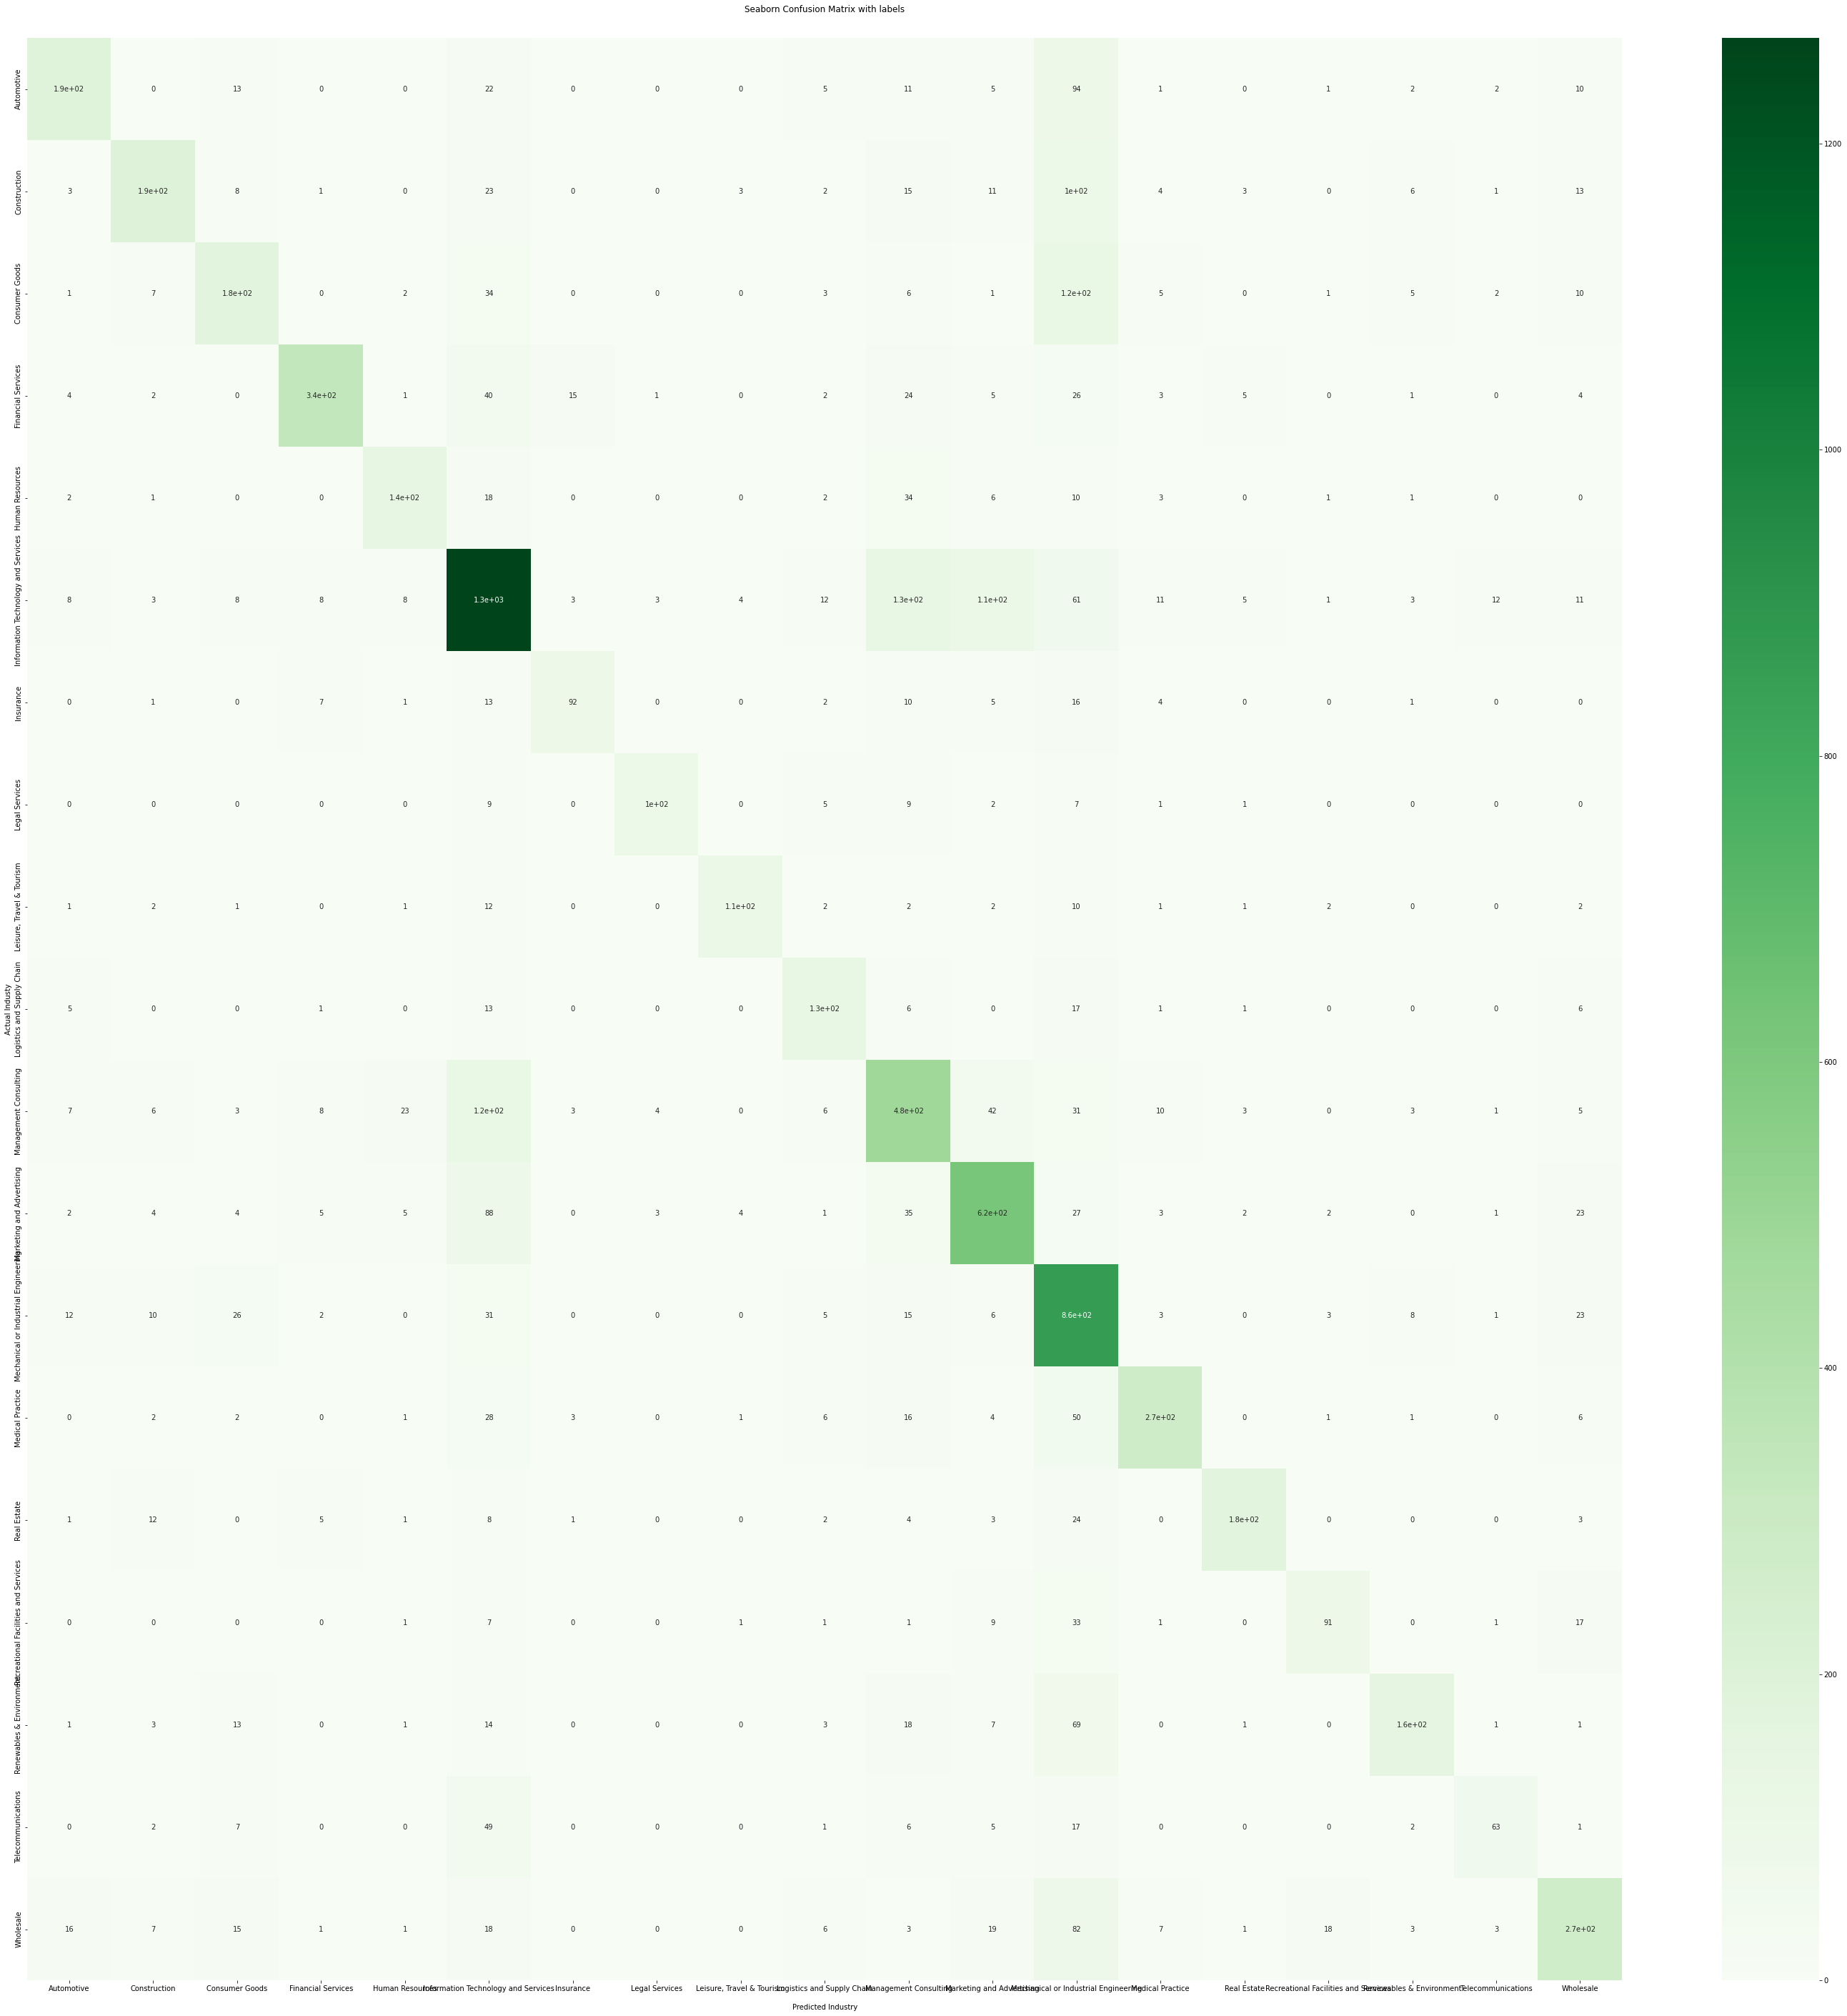

In [ ]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
cf_matrix = metrics.confusion_matrix(test_y, predicted)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 50))

sns.heatmap(cf_matrix, annot=True, cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Industry')
ax.set_ylabel('Actual Industy');

# list of labels
industries = df_train['industry_label'].tolist()
industries = sorted(set(industries))

# ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(industries)
ax.yaxis.set_ticklabels(industries)

# display the visualization of the Confusion Matrix.
plt.show()

AUC ROC scoring

https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659

In [ ]:
def multiclass_roc_auc_score(val_y, predicted, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(val_y)
  val_y = lb.transform(val_y)
  predicted = lb.transform(predicted)
  return metrics.roc_auc_score(val_y, predicted, average=average)

multiclass_roc_auc_score(test_y,predicted)

0.8115262165951082

### Save & reload model

Following: https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn

In [ ]:
logit.sparsify()
# save model and vectorizer to file
with open('log_tfidf.pkl', 'wb') as f:
    pickle.dump((vectorizer, logit), f)

drive.mount('/gdrive')
!cp log_tfidf.pkl '/gdrive/MyDrive/industry_data_processed/models/logistic_regression' 

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# reload methos -> used in app
drive.mount('/gdrive')
data_path = Path('/gdrive/MyDrive/industry_data_processed/models/logistic_regression')
file_name = 'log_tfidf.pkl'

# load model
with open(data_path/file_name, 'rb') as f:
    vectorizer_loaded, logit_loaded = pickle.load(f)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Imbalanced data

In [ ]:
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

###Oversampling

https://imbalanced-learn.org/stable/over_sampling.html

Results: Depends. On train dataset there is a rise in metrics. However, prefer class weighting or combination of over- and undersampling.



In [ ]:
# Synthetic Minority Oversampling Technique
# interpolating new points between marginal outliers and inliers
X_resampled_up, y_resampled_up = SMOTE().fit_resample(train_X, train_y)

In [ ]:
print(sorted(Counter(y_resampled_up).items()))

[('Automotive', 2144), ('Construction', 2144), ('Consumer Goods', 2144), ('Financial Services', 2144), ('Human Resources', 2144), ('Information Technology and Services', 2144), ('Insurance', 2144), ('Legal Services', 2144), ('Leisure, Travel & Tourism', 2144), ('Logistics and Supply Chain', 2144), ('Management Consulting', 2144), ('Marketing and Advertising', 2144), ('Mechanical or Industrial Engineering', 2144), ('Medical Practice', 2144), ('Real Estate', 2144), ('Recreational Facilities and Services', 2144), ('Renewables & Environment', 2144), ('Telecommunications', 2144), ('Wholesale', 2144)]


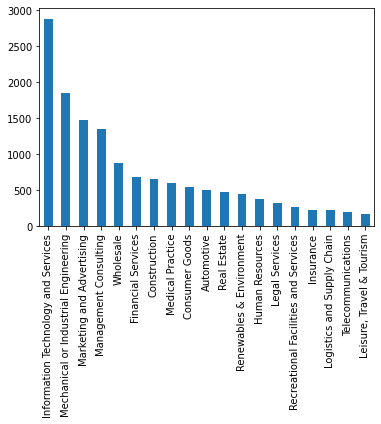

In [ ]:
df_train.industry_label.value_counts().plot(kind='bar')

###Undersampling

https://imbalanced-learn.org/stable/combine.html

Results: Little rise in metrics, not too much when using train dataset only. Drop of metric when using pre-splitted train and test data.

In [ ]:
# subset of data for the targeted classes
rus = RandomUnderSampler(random_state=42)

In [ ]:
X_resampled_under, y_resampled_under = rus.fit_resample(train_X, train_y)

In [ ]:
print(sorted(Counter(y_resampled_under).items()))

[('Automotive', 207), ('Construction', 207), ('Consumer Goods', 207), ('Financial Services', 207), ('Human Resources', 207), ('Information Technology and Services', 207), ('Insurance', 207), ('Legal Services', 207), ('Leisure, Travel & Tourism', 207), ('Logistics and Supply Chain', 207), ('Management Consulting', 207), ('Marketing and Advertising', 207), ('Mechanical or Industrial Engineering', 207), ('Medical Practice', 207), ('Real Estate', 207), ('Recreational Facilities and Services', 207), ('Renewables & Environment', 207), ('Telecommunications', 207), ('Wholesale', 207)]


### Combination: Under- and Oversampling

Results: SMOTETomek worked better, raise in metrics when using train dataset only.

In [ ]:
smote_enn = SMOTEENN(random_state=0)
smote_tomek = SMOTETomek(random_state=0)

In [ ]:
# may take some time
X_resampled_both, y_resampled_both = smote_tomek.fit_resample(train_X, train_y) # or exchange with smote_enn (performance is better on tomek)

In [ ]:
print(sorted(Counter(y_resampled_both).items()))

[('Automotive', 3474), ('Construction', 3472), ('Consumer Goods', 3472), ('Financial Services', 3474), ('Human Resources', 3474), ('Information Technology and Services', 3443), ('Insurance', 3474), ('Legal Services', 3474), ('Leisure, Travel & Tourism', 3474), ('Logistics and Supply Chain', 3474), ('Management Consulting', 3458), ('Marketing and Advertising', 3460), ('Mechanical or Industrial Engineering', 3462), ('Medical Practice', 3474), ('Real Estate', 3473), ('Recreational Facilities and Services', 3474), ('Renewables & Environment', 3474), ('Telecommunications', 3473), ('Wholesale', 3471)]


# Alternatives: Results and tests on combinations

Here, the rest of combinations are saved. They were not used for the logistic regression model in the app.

In [ ]:
# use this when working on train only

#y = df_train['industry_label']
#X = df_train['concatenated']
# train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

**Alternative: Multi-column on the pre-splitted train test data**

In [ ]:
logit_mc = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4, class_weight = 'balanced') 

# https://scikit-learn.org/stable/modules/compose.html#feature-union
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
column_trans = ColumnTransformer(transformers=[
     ('text', TfidfVectorizer(max_features=400000), 'concatenated'),
     ('imputer', SimpleImputer(strategy='median'), ['sentiment_analysis']), # 'sentiment_analysis' is 1D, however 2D is expected -> use []
  ], remainder='drop', verbose_feature_names_out=False)

# we tested several combinations and all columns in the column transformer
# the best results were achieved with the concatenated text and the sentiment-analysis

In [ ]:
train_X_mc = df_train.drop(['url', 'industry', 'industry_label'], axis=1).copy()
train_y_mc = df_train['industry_label'].copy().values.reshape(-1, 1)

test_X_mc = df_test.drop(['url', 'industry', 'industry_label'], axis=1).copy()
test_y_mc = df_test['industry_label'].copy().values.reshape(-1, 1)

train_y_mc.tolist()
test_y_mc.tolist()

train_X_mc.shape, train_y_mc.shape

In [ ]:
pipeline = Pipeline(steps=[('t', column_trans), ('m',logit_mc)])

In [ ]:
pipeline.fit(train_X_mc, train_y_mc.ravel())

In [ ]:
pipeline.score(test_X_mc, test_y_mc.ravel())

0.5270366841353026

In [ ]:
# check out pipeline with cross-validation
results = cross_validate(pipeline, train_X_mc, train_y_mc.ravel(), return_train_score=True, cv=3)
results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

**Alternative: Combine both datasets and re-split (check out with stratified k-fold cross-validation)**

In contrast to the other scores of the pre-splittet data sets, here the scores go up.

In [ ]:
y = pd.concat([df_train['industry_label'], df_test['industry_label']], ignore_index=True)
X = pd.concat([df_train['concatenated'], df_test['concatenated']], ignore_index=True)

In [ ]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)

acc_stratified = []

for train_index,test_index in skf.split(X,y):
  X_train, X_test = vectorizer.fit_transform(X[train_index]), vectorizer.transform(X[test_index])
  y_train, y_test = (y[train_index]).tolist(), (y[test_index]).tolist()

  logit.fit(X_train, y_train) 
  
  acc_stratified.append(logit.score(X_test, y_test))

print('Accuracy over folds:', acc_stratified)

Accuracy over folds: [0.7535702951443985, 0.7625773686716394, 0.7513093159815902, 0.7470242818600222]


**Alternative: Model with naive bayes classifier**

The results are way behind the logistic regression. Low score -> wouldn't recommend, no further usage.

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f



In [ ]:
nb = MultinomialNB().fit(train_X, train_y)

In [ ]:
score = nb.score(test_X, test_y)
score

0.25762267746545975

### Summary of the results


**Train dataset with regular train-test-split**

* With unfiltered data, regular train_X, train_y: 
  * 6 min
  * score 0.71 
* Upsampled (oversampling) data X, y (shouldnt be done this way, duplicates in test)
  * 12 min
* Upsampled data train_X, train_y (do oversampling after split, only on train)
  * 16 min 
  * 0.72
* Undersampling on train-split with random undersampler:
  * 0.67
* Combination of under and oversampling
  * smote_enn: 11 min, 0.6
  * smote_tomek: 15 min, 0.72 
* Filtered german data (lang_code = de)
  * 0.73
* Filtered germand data + smote_tomek
  * 7 min
  * 0.75

**Pre-splitten train and test dataset filtered for German data**

* With regular train_X, train_y: 
  * 0.68
* Upsampled data train_X, train_y (do oversampling after split, only on train)
  * 0.68
* Undersampling on train-split with random undersampler:
  * 0.61
* Combination of under and oversampling
  * smote_tomek: 0.68